In [15]:
# Allow interactive plots
%matplotlib widget
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' # This avoids crashes on the math cluster from using to many resources
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from analysis_library import *
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
from matplotlib import animation
import scipy as sp
matplotlib.rcParams.update({'font.size': 10})


In [16]:
name_pairs = [['/HighDensitycontrolEphB2/High Density control EphB2_green frames 0 to 211_Tracks',
        '/HighDensitycontrolEphB2/High Density control EphB2_red frames 0 to 211_Tracks'],
        ['/High Density sorting EphB2/High Density sorting EphB2_green frames 0 to 211_Tracks',
        '/High Density sorting EphB2/High Density sorting ephrinB1_red 0 to 211_Tracks'],
        ['/Low Density sorting ephrinB1/Low Density sorting EphB2_green frames 11 to 211_Tracks',
        '/Low Density sorting ephrinB1/Low Density sorting ephrinB1_red frames 11 to 211_Tracks']
        ]

min_length = 1 #Tracks shorter than that are excluded
sourceFolder = '/home/marius/PhD/CellMotility/tracking_23_01'
outputFolder = '/home/marius/PhD/CellMotility/Plots/Plots_2023_01'
pair = name_pairs[2]

In [17]:
#Load green tracks
green_name = pair[0][:pair[0].find('f')]
green = experiment(green_name)
green.read_xml(sourceFolder+pair[0]+'.xml', min_length)



#Load red tracks
red_name = pair[1][:pair[1].find('f')]
red = experiment(red_name)
red.read_xml(sourceFolder+pair[1]+'.xml', min_length)

Read xml file in 0.775085 seconds
Read xml file in 0.645166 seconds


AssertionError: No points found at this time.

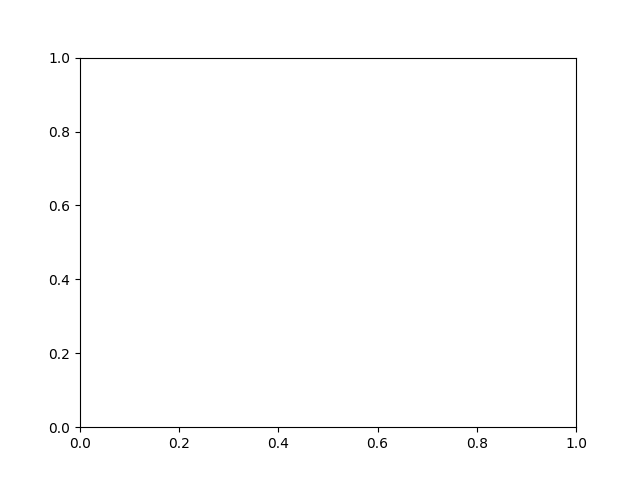

In [10]:
#RDF
n_bins = 300 
cutoff_percentage = 70
n_reference_points = 20000
times = [10,190]#np.linspace(0,190,20) 
fig, axes = plt.subplots(1,1)
#Green particles
green.plot_radial_density(axes, time , n_bins, 'Green cells','g',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
#red particles
red.plot_radial_density(axes, time , n_bins, 'Red cells','r',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
#red-green crosscorrelation
plot_mixed_particle_radial_density(axes, [green,red], time ,n_bins, n_reference_points, 
                                    cutoff_percentage=cutoff_percentage)
bin_size = np.sqrt(green.x_max**2+green.y_max**2)/n_bins
axes.set_title('t = %d, bin size = %f'%(time,bin_size))
subfolder = green_name[:green_name.find('/',1,len(green_name))]

In [45]:
# MSD
greenMSD, greenTimes = green.MSD()
redMSD, redTimes = red.MSD()
greenTimes.shape

(200,)

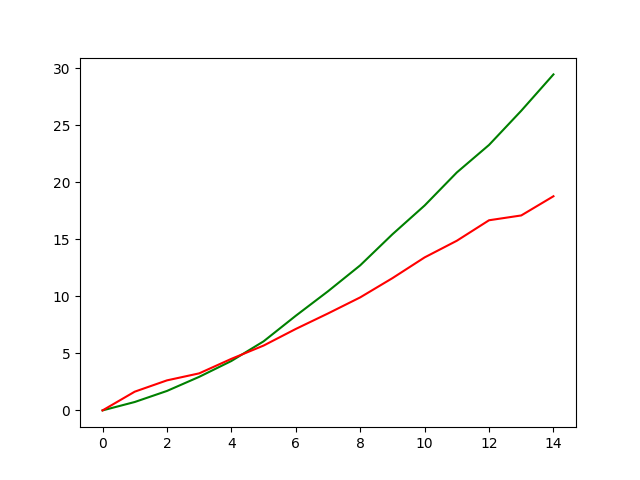

In [46]:
fig,ax = plt.subplots(1,1)
cutoff = 15
ax.plot(greenTimes[0:cutoff], greenMSD[0:cutoff],color="green")
ax.plot(redTimes[0:cutoff], redMSD[0:cutoff], color="red")


In [47]:
# fig.savefig(outputFolder+pair[0]+"_MSD.pdf",dpi=500)

In [76]:
# Fit to MSD of ABPs
X = greenTimes[0:cutoff]
def f(t,v, tau, D):
    return (2*D+2*v**2*tau)*t+2*v**2*tau**2 *(np.exp(-t/tau)-1)
par_green, parVar_green = sp.optimize.curve_fit(f,X, greenMSD[0:cutoff], bounds=(0,1000))
v_green = par_green[0]
tau_green = par_green[1]
D_green = par_green[2]
par_red, parVar_red = sp.optimize.curve_fit(f,X, redMSD[0:cutoff], bounds=(0,1000))
v_red = par_red[0]
tau_red = par_red[1]
D_red = par_red[2]
print(par_green, par_red)
print(tau_green, tau_red)
print(parVar_green, parVar_red)
Y_green = f(X, par_green[0], par_green[1], par_green[2])
Y_red = f(X, par_red[0], par_red[1], par_red[2])

[0.4494182  7.63177698 0.21338065] [0.22765002 5.55409529 0.49791434]
7.631776983368292 5.5540952917543445
[[ 4.08517715e-04 -1.95990175e-02 -5.89332117e-04]
 [-1.95990175e-02  9.70671128e-01  2.71978921e-02]
 [-5.89332117e-04  2.71978921e-02  8.92662771e-04]] [[ 2.09623127e-02 -1.13714897e+00 -1.36891976e-02]
 [-1.13714897e+00  6.37087775e+01  7.15200576e-01]
 [-1.36891976e-02  7.15200576e-01  9.34683246e-03]]


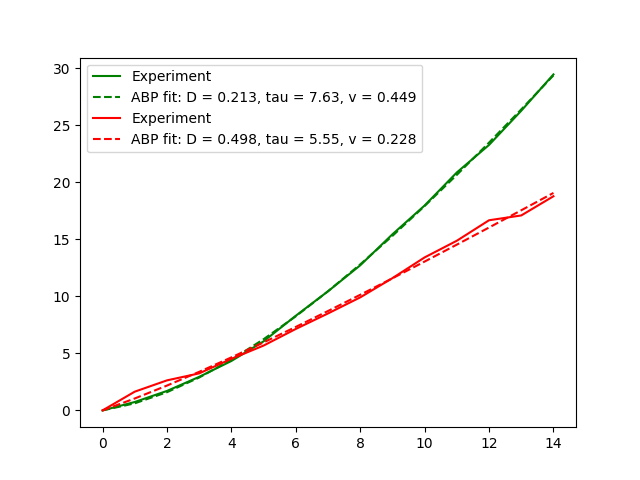

In [77]:
fig,ax = plt.subplots(1,1)
ax.plot(X, greenMSD[0:cutoff],color="green", label="Experiment")
ax.plot(X,Y_green, linestyle="--", color="green",  label=f"ABP fit: D = {D_green:.3}, tau = {tau_green:.3}, v = {v_green:.3}")
ax.plot(X, redMSD[0:cutoff],color="red", label="Experiment")
ax.plot(X,Y_red, linestyle="--", color="red",  label=f"ABP fit: D = {D_red:.3}, tau = {tau_red:.3}, v = {v_red:.3}")
ax.legend()


In [50]:
fig.savefig(outputFolder+pair[0]+"_MSD.pdf",dpi=500)

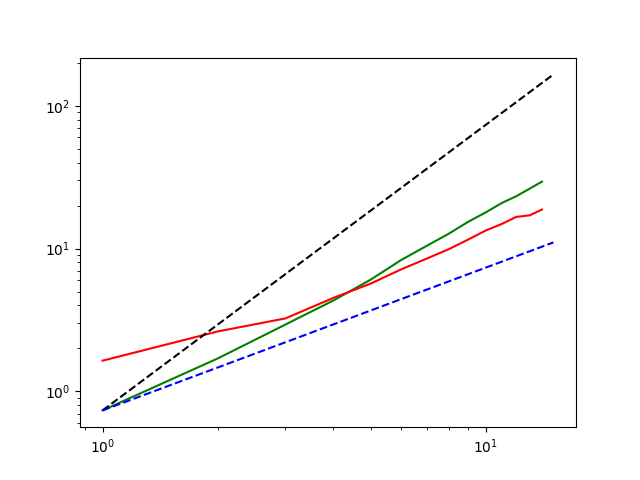

In [51]:
fig,ax = plt.subplots(1,1)
plt.loglog(greenTimes[1:cutoff], greenMSD[1:cutoff],color="green")
plt.loglog(redTimes[1:cutoff], redMSD[1:cutoff], color="red")
tmax = greenTimes[cutoff]
#Ballistic motion, starting on the left
x0 = greenMSD[1]
x1 = greenMSD[1]*(tmax)**2 
ax.loglog([greenTimes[1],greenTimes[cutoff]],[x0,x1],color='black', 
            linestyle='dashed', label='Ballistic motion')

#Normal diffusive motion, 
y0 = greenMSD[1]
y1 = greenMSD[1]*(tmax) 
ax.loglog([greenTimes[1],greenTimes[cutoff]],[y0,y1],color='blue', 
            linestyle='dashed', label='Diffusive motion')


In [52]:
# fig.savefig(outputFolder+pair[0]+"_MSD_loglog.pdf",dpi=500)

In [79]:
# Fit to MSD of ABPs without translational diffusion
X = greenTimes[0:cutoff]
def f1(t,v, tau):
    return (2*v**2*tau)*t+2*v**2*tau**2 *(np.exp(-t/tau)-1)
par_green, parVar_green = sp.optimize.curve_fit(f1,X, greenMSD[0:cutoff], bounds=(0,1000))
v_green = par_green[0]
tau_green = par_green[1]
par_red, parVar_red = sp.optimize.curve_fit(f1,X, redMSD[0:cutoff], bounds=(0,1000))
v_red = par_red[0]
tau_red = par_red[1]
print(par_green, par_red)
print(tau_green, tau_red)
print(parVar_green, parVar_red)
Y_green = f1(X, par_green[0], par_green[1])
Y_red = f1(X, par_red[0], par_red[1])

[0.58944873 4.21803582] [1.02073904 0.67660919]
4.218035824291927 0.6766091889099658
[[ 0.0001035  -0.00254375]
 [-0.00254375  0.0636104 ]] [[ 0.02292604 -0.03274037]
 [-0.03274037  0.046824  ]]


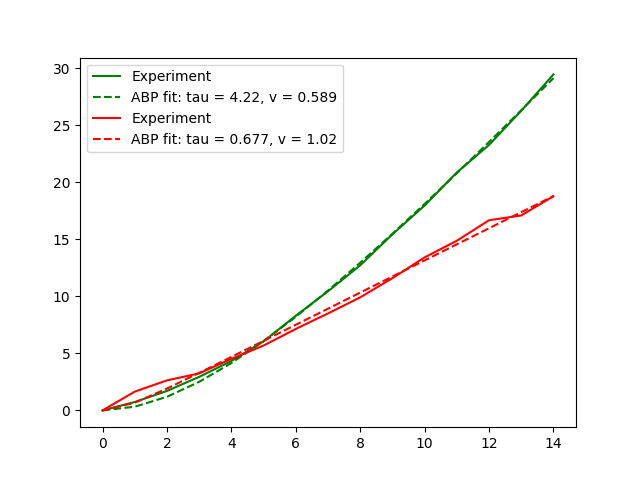

In [80]:
fig,ax = plt.subplots(1,1)
ax.plot(X, greenMSD[0:cutoff],color="green", label="Experiment")
ax.plot(X,Y_green, linestyle="--", color="green",  label=f"ABP fit: tau = {tau_green:.3}, v = {v_green:.3}")
ax.plot(X, redMSD[0:cutoff],color="red", label="Experiment")
ax.plot(X,Y_red, linestyle="--", color="red",  label=f"ABP fit: tau = {tau_red:.3}, v = {v_red:.3}")
ax.legend()


In [55]:
fig.savefig(outputFolder+pair[0]+"_MSD_no_diffusion.pdf",dpi=500)

[ 0.81269126  1.7741971   3.14162685  4.83062144  6.75542394  8.83802743
 11.02991675 13.28936957 15.58356467 17.90090825 20.22839991 22.57555961
 24.91272157 27.22886028 29.51882516 31.77893445 34.00926807 36.21035593
 38.39852844 40.55761174 42.70708837 44.84257915 46.96062877 49.07522331
 51.17645067 53.27636685 55.35967154 57.43632008 59.50788525 61.57045189
 63.63282497 65.71525387 67.80065118 69.91161781 72.0238286  74.15169781
 76.30534288 78.45681956 80.5934894  82.74585877]


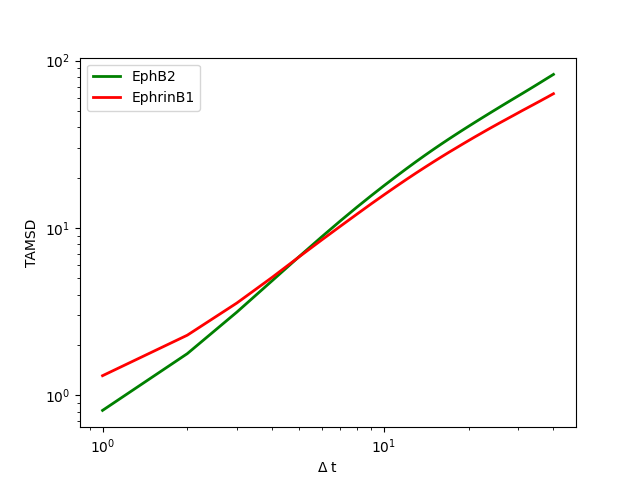

In [56]:
#TAMSD
fig,ax = plt.subplots(1,1)
tMax = 40
green_times, green_TAMSD = green.plot_TAMSD(tMax,tMax+10,ax,"EphB2","green", reference=False)
red_times, red_TAMSD = red.plot_TAMSD(tMax,tMax+10,ax,"EphrinB1","red", reference=False)
plt.legend()
print(green_TAMSD)

In [81]:
# Fit to TAMSD of ABPs
X = green_times
def f(t,v, tau, D):
    return (2*D+2*v**2*tau)*t+2*v**2*tau**2 *(np.exp(-t/tau)-1)
par_green, parVar_green = sp.optimize.curve_fit(f,X, green_TAMSD, bounds=(0,1000))
v_green = par_green[0]
tau_green = par_green[1]
D_green = par_green[2]
par_red, parVar_red = sp.optimize.curve_fit(f,X, red_TAMSD, bounds=(0,1000))
v_red = par_red[0]
tau_red = par_red[1]
D_red = par_red[2]
print(par_green, par_red)
print(tau_green, tau_red)
print(parVar_green, parVar_red)
Y_green = f(X, par_green[0], par_green[1], par_green[2])
Y_red = f(X, par_red[0], par_red[1], par_red[2])

[8.25587366e-01 1.58973944e+00 1.88834444e-17] [2.15374617e+00 1.75550066e-01 6.77092466e-07]
1.5897394369890583 0.1755500660902857
[[ 0.04581979 -0.09329928 -0.05706441]
 [-0.09329928  0.19179297  0.11510361]
 [-0.05706441  0.11510361  0.07172861]] [[116968.90925497  -9543.1178432  -44183.23608435]
 [ -9543.1178432     778.59904885   3604.73774653]
 [-44183.23608435   3604.73774653  16689.68945101]]


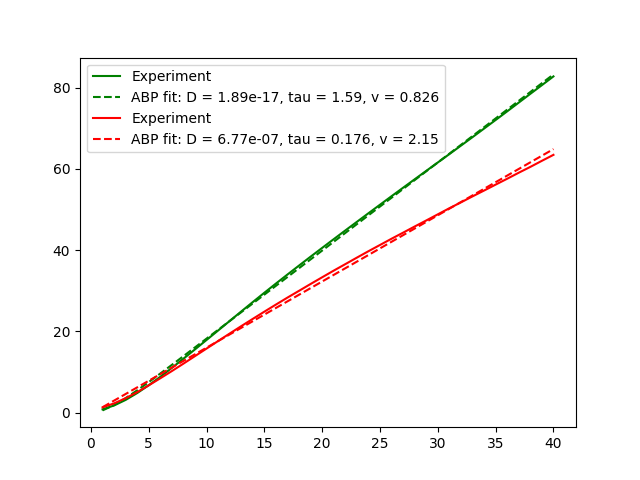

In [82]:
fig,ax = plt.subplots(1,1)
ax.plot(green_times, green_TAMSD,color="green", label="Experiment")
ax.plot(X,Y_green, linestyle="--", color="green",  label=f"ABP fit: D = {D_green:.3}, tau = {tau_green:.3}, v = {v_green:.3}")
ax.plot(red_times, red_TAMSD,color="red", label="Experiment")
ax.plot(X,Y_red, linestyle="--", color="red",  label=f"ABP fit: D = {D_red:.3}, tau = {tau_red:.3}, v = {v_red:.3}")
ax.legend()
fig.savefig(outputFolder+pair[0]+"_TAMSD.pdf",dpi=500)

In [83]:
# Fit to TAMSD of ABPs without diffuion
X = green_times
def f1(t,v, tau):
    return (2*v**2*tau)*t+2*v**2*tau**2 *(np.exp(-t/tau)-1)
par_green, parVar_green = sp.optimize.curve_fit(f1,X, green_TAMSD, bounds=(0,1000))
v_green = par_green[0]
tau_green = par_green[1]
par_red, parVar_red = sp.optimize.curve_fit(f1,X, red_TAMSD, bounds=(0,1000))
v_red = par_red[0]
tau_red = par_red[1]
print(par_green, par_red)
print(tau_green, tau_red)
print(parVar_green, parVar_red)
Y_green = f1(X, par_green[0], par_green[1])
Y_red = f1(X, par_red[0], par_red[1])

[0.82558733 1.5897396 ] [2.1538664  0.17553049]
1.5897396024198227 0.17553048646339098
[[ 0.00041053 -0.00168199]
 [-0.00168199  0.00689862]] [[ 0.95827138 -0.15721409]
 [-0.15721409  0.02579292]]


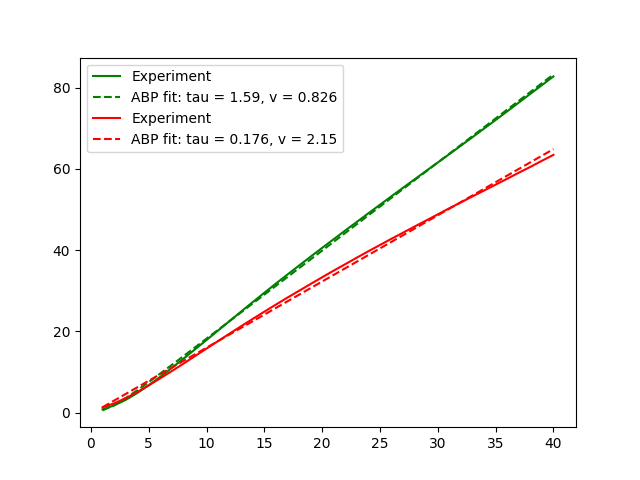

In [84]:
fig,ax = plt.subplots(1,1)
ax.plot(green_times, green_TAMSD,color="green", label="Experiment")
ax.plot(X,Y_green, linestyle="--", color="green",  label=f"ABP fit: tau = {tau_green:.3}, v = {v_green:.3}")
ax.plot(red_times, red_TAMSD,color="red", label="Experiment")
ax.plot(X,Y_red, linestyle="--", color="red",  label=f"ABP fit: tau = {tau_red:.3}, v = {v_red:.3}")
ax.legend()
fig.savefig(outputFolder+pair[0]+"_TAMSD_no_diffusion.pdf",dpi=500)

In [41]:
# Mixing index

Read .csv track file in 0.380334 seconds


KeyboardInterrupt: 

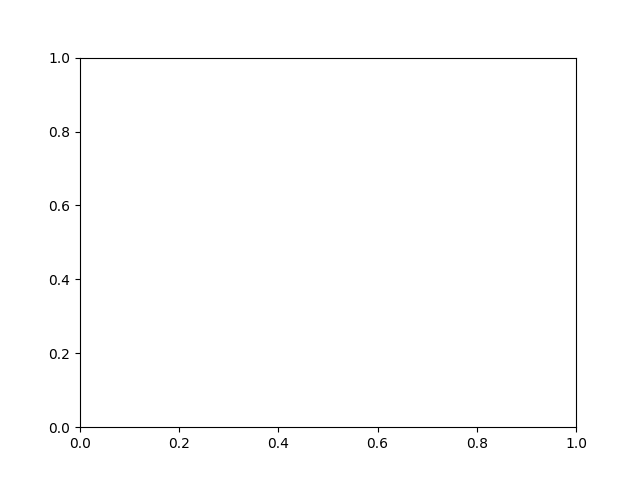

In [21]:
# Simulation data
PATH = "/home/marius/PhD/CellMotility/agent_simulation/output_23_01/diffCIL_persistence/movies/A_0.5_Pe_20"
green_sim, red_sim, params_sim = load_simulation_data(PATH, trackIdx="_1")
n_bins = 500
cutoff_percentage = 30
n_reference_points = 2000
fig, axes = plt.subplots(1,1)
t_final = green_sim.tracks[0][-1][0]
#Green particles
green_sim.plot_radial_density(axes, t_final , n_bins, 'Green cells','g',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
#red particles
red_sim.plot_radial_density(axes, t_final , n_bins, 'Red cells','r',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
# #red-green crosscorrelation
plot_mixed_particle_radial_density(axes, [green_sim,red_sim], t_final ,n_bins, n_reference_points, 
                                    cutoff_percentage=cutoff_percentage)
# fig.savefig(PATH+"_RDF.pdf")

In [ ]:
# Simulation data
PATH = "/home/marius/PhD/CellMotility/agent_simulation/output_23_01/diffCIL_persistence/movies/A_0.5_Pe_60"
green_sim, red_sim, params_sim = load_simulation_data(PATH, trackIdx="_1")
n_bins = 500
cutoff_percentage = 30
n_reference_points = 2000
fig, axes = plt.subplots(1,1)
t_final = green_sim.tracks[0][-1][0]
#Green particles
green_sim.plot_radial_density(axes, t_final , n_bins, 'Green cells','g',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
#red particles
red_sim.plot_radial_density(axes, t_final , n_bins, 'Red cells','r',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
# #red-green crosscorrelation
plot_mixed_particle_radial_density(axes, [green_sim,red_sim], t_final ,n_bins, n_reference_points, 
                                    cutoff_percentage=cutoff_percentage)

In [ ]:
# Simulation data
PATH = "/home/marius/PhD/CellMotility/agent_simulation/output_23_01/diffCIL_persistence/movies/A_0.5_Pe_140"
green_sim, red_sim, params_sim = load_simulation_data(PATH, trackIdx="_1")
n_bins = 500
cutoff_percentage = 60
n_reference_points = 2000
fig, axes = plt.subplots(1,1)
t_final = green_sim.tracks[0][-1][0]
#Green particles
green_sim.plot_radial_density(axes, t_final , n_bins, 'Green cells','g',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
#red particles
red_sim.plot_radial_density(axes, t_final , n_bins, 'Red cells','r',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
# #red-green crosscorrelation
plot_mixed_particle_radial_density(axes, [green_sim,red_sim], t_final ,n_bins, n_reference_points, 
                                    cutoff_percentage=cutoff_percentage)
# fig.savefig(PATH+"_RDF.pdf")

In [ ]:
# Simulation data
PATH = "/home/marius/PhD/CellMotility/agent_simulation/output_23_01/diffCIL_persistence/movies/A_0.7_Pe_80"
green_sim, red_sim, params_sim = load_simulation_data(PATH, trackIdx="_1")
n_bins = 500
cutoff_percentage = 60
n_reference_points = 2000
fig, axes = plt.subplots(1,1)
t_final = green_sim.tracks[0][-1][0]
#Green particles
green_sim.plot_radial_density(axes, t_final , n_bins, 'Green cells','g',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
#red particles
red_sim.plot_radial_density(axes, t_final , n_bins, 'Red cells','r',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
# #red-green crosscorrelation
plot_mixed_particle_radial_density(axes, [green_sim,red_sim], t_final ,n_bins, n_reference_points, 
                                    cutoff_percentage=cutoff_percentage)
# fig.savefig(PATH+"_RDF.pdf")

In [ ]:
# Simulation data
PATH = "/home/marius/PhD/CellMotility/agent_simulation/output_23_01/diffCIL_persistence/movies/A_0.3_Pe_20"
green_sim, red_sim, params_sim = load_simulation_data(PATH, trackIdx="_1")
n_bins = 500
cutoff_percentage = 60
n_reference_points = 2000
fig, axes = plt.subplots(1,1)
t_final = green_sim.tracks[0][-1][0]
#Green particles
green_sim.plot_radial_density(axes, t_final , n_bins, 'Green cells','g',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
#red particles
red_sim.plot_radial_density(axes, t_final , n_bins, 'Red cells','r',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
# #red-green crosscorrelation
plot_mixed_particle_radial_density(axes, [green_sim,red_sim], t_final ,n_bins, n_reference_points, 
                                    cutoff_percentage=cutoff_percentage)
fig.savefig(PATH+"_RDF.pdf")

In [ ]:
# Simulation data
PATH = "/home/marius/PhD/CellMotility/agent_simulation/output_new_parameters/turnAround_persistence_t_100/areaFraction_0.5_Pe_120"
green_sim, red_sim, params_sim = load_simulation_data(PATH, trackIdx="_1")
n_bins = 500
cutoff_percentage = 60
n_reference_points = 2000
fig, axes = plt.subplots(1,1)
t_final = green_sim.tracks[0][-1][0]
#Green particles
green_sim.plot_radial_density(axes, t_final , n_bins, 'Green cells','g',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
#red particles
red_sim.plot_radial_density(axes, t_final , n_bins, 'Red cells','r',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
# #red-green crosscorrelation
plot_mixed_particle_radial_density(axes, [green_sim,red_sim], t_final ,n_bins, n_reference_points, 
                                    cutoff_percentage=cutoff_percentage)
fig.savefig(PATH+"_RDF.pdf")


In [ ]:
# Simulation data
PATH = "/home/marius/PhD/CellMotility/agent_simulation/output_new_parameters/turnAround_persistence_t_100/areaFraction_0.5_Pe_40"
green_sim, red_sim, params_sim = load_simulation_data(PATH, trackIdx="_1")
n_bins = 500
cutoff_percentage = 60
n_reference_points = 2000
fig, axes = plt.subplots(1,1)
t_final = green_sim.tracks[0][-1][0]
#Green particles
green_sim.plot_radial_density(axes, t_final , n_bins, 'Green cells','g',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
#red particles
red_sim.plot_radial_density(axes, t_final , n_bins, 'Red cells','r',cutoff_percentange = cutoff_percentage, 
                        n_reference_points = n_reference_points)
# #red-green crosscorrelation
plot_mixed_particle_radial_density(axes, [green_sim,red_sim], t_final ,n_bins, n_reference_points, 
                                    cutoff_percentage=cutoff_percentage)
fig.savefig(PATH+"_RDF.pdf")
